# ETL Movies:

## Propuesta de trabajo (requerimientos de aprobación)
Transformaciones: Para este MVP no necesitas perfección, ¡necesitas rapidez! ⏩ Vas a hacer estas, y solo estas, transformaciones a los datos:

* 1 Algunos campos, como belongs_to_collection, production_companies y otros (ver diccionario de datos) están anidados, esto es o bien tienen un diccionario o una lista como valores en cada fila, ¡deberán desanidarlos para poder y unirlos al dataset de nuevo hacer alguna de las consultas de la API! O bien buscar la manera de acceder a esos datos sin desanidarlos.

* 2 Los valores nulos de los campos revenue, budget deben ser rellenados por el número 0.

* 3 Los valores nulos del campo release date deben eliminarse.

* 4 De haber fechas, deberán tener el formato AAAA-mm-dd, además deberán crear la columna release_year donde extraerán el año de la fecha de estreno.

* 5 Crear la columna con el retorno de inversión, llamada return con los campos revenue y budget, dividiendo estas dos últimas revenue / budget, cuando no hay datos disponibles para calcularlo, deberá tomar el valor 0.

* 6 Eliminar las columnas que no serán utilizadas, video,imdb_id,adult,original_title,poster_path y homepage.

## Ingesta de Datasets:

In [1]:
import pandas as pd

csvs_to_read = [1, 2, 3]
dfs = []
encodings = ['ANSI', 'ANSI', 'UTF-8']

for i, number in enumerate(csvs_to_read):
    df = pd.read_csv(f'D:\Data Scientist\CURSADO HENRY DTS09\PI\PI1_PT02\PI_ML_OPS_PT02\Datasets\Movies_datasets\CSVs Movies\movies_dataset_{number}.csv', encoding=encodings[i], sep=',',low_memory=False)
    dfs.append(df)

# Concatenar todos los DataFrames en uno solo
df_movies = pd.concat(dfs, ignore_index=True)

# Ahora df_movies contiene todos los datos de los tres CSVs en un solo DataFrame

In [2]:
df_movies.shape

(136398, 24)

In [3]:
df_movies.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,FALSO,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,FALSO,7.7,5415.0
1,FALSO,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,FALSO,6.9,2413.0
2,FALSO,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,FALSO,6.5,92.0
3,FALSO,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,FALSO,6.1,34.0
4,FALSO,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,FALSO,5.7,173.0


## * 6 Eliminar las columnas que no serán utilizadas, video,imdb_id,adult,original_title,poster_path y homepage.

In [4]:
# Suponiendo que ya tienes el DataFrame df_movies cargado o creado

# Lista de columnas a eliminar
columnas_a_eliminar = ['video', 'imdb_id', 'adult', 'original_title', 'poster_path', 'homepage','belongs_to_collection', 'tagline']

# Utilizamos el método drop() para eliminar las columnas
df_movies = df_movies.drop(columnas_a_eliminar, axis=1)

# Si quieres aplicar los cambios directamente en el DataFrame original sin crear una copia, puedes usar el argumento inplace=True
# df_movies.drop(columnas_a_eliminar, axis=1, inplace=True)


In [5]:
import missingno as msno

<Axes: >

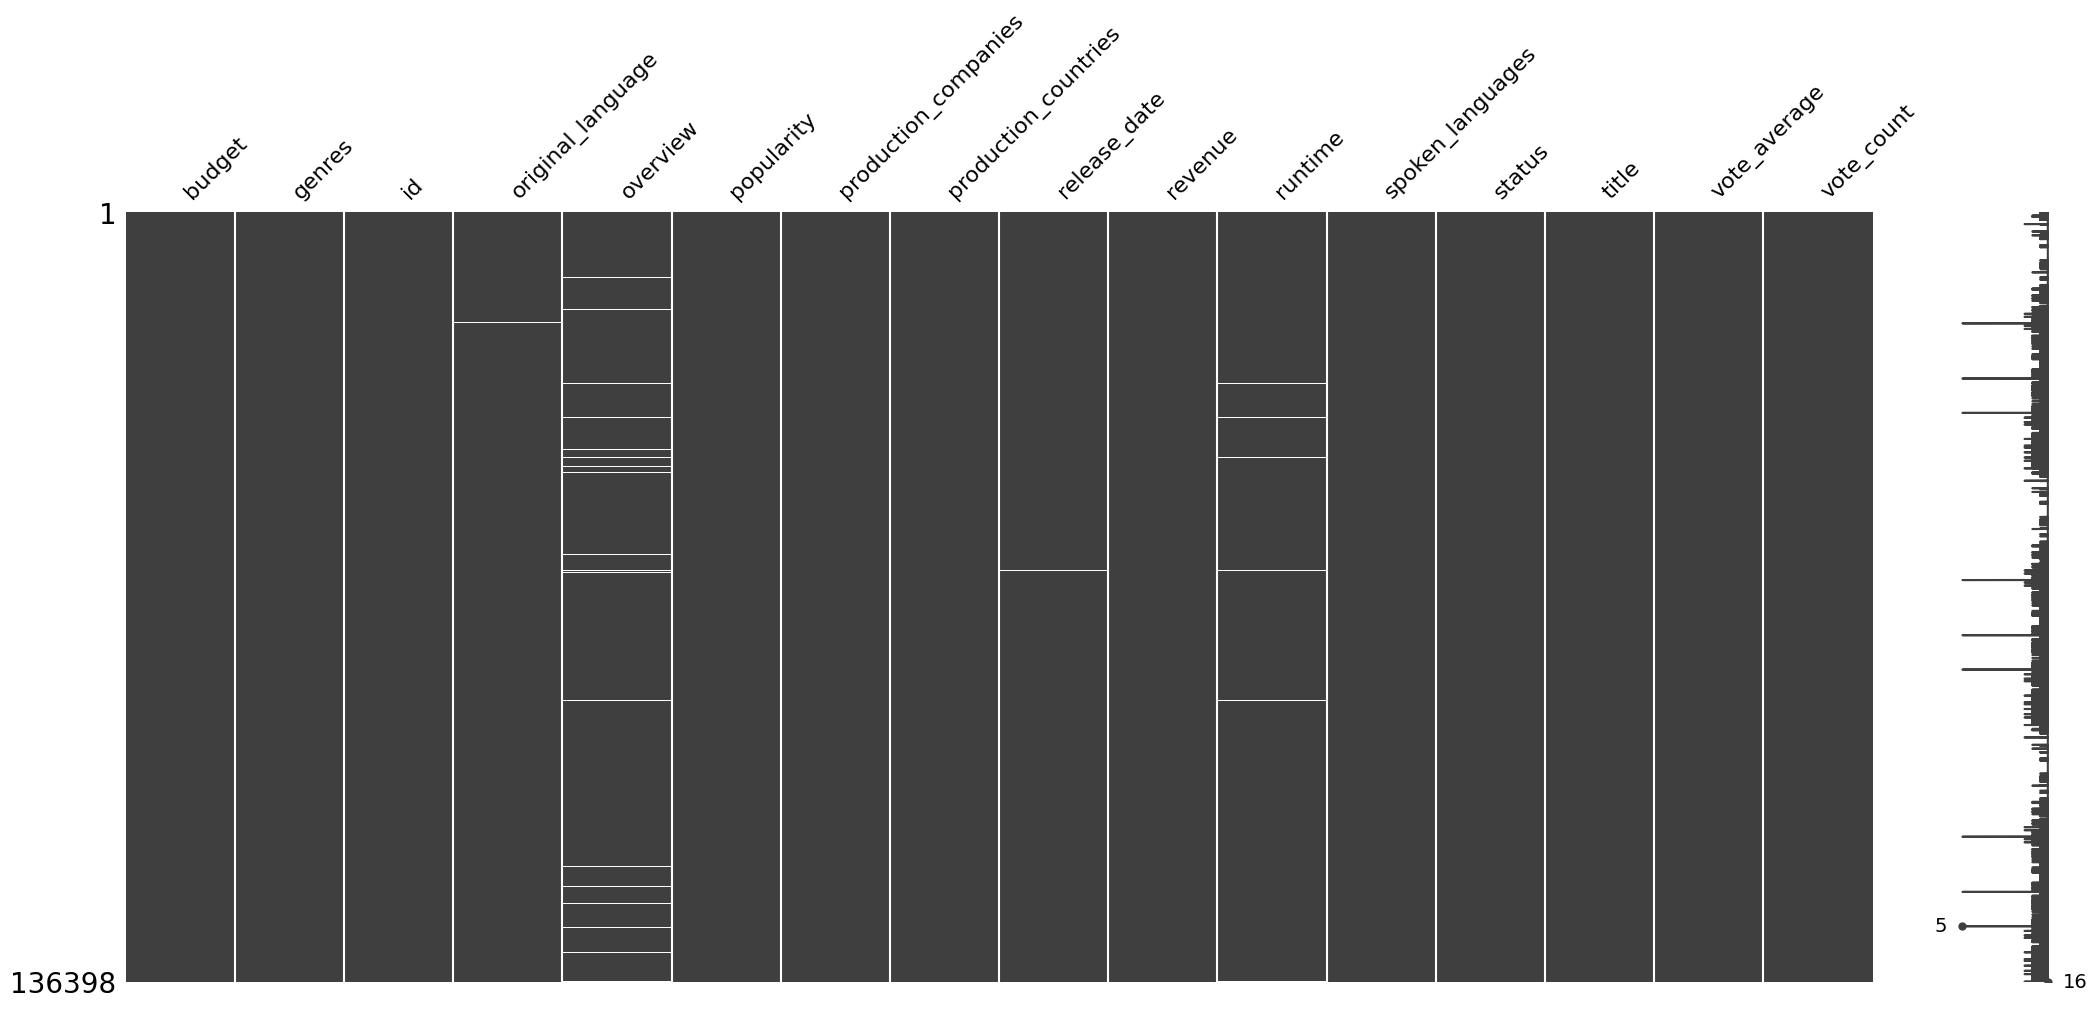

In [6]:
msno.matrix(df_movies)

## Desarmando los diccionarios dentro..

In [7]:
columns_to_separate = pd.DataFrame(df_movies['genres'])
columns_to_separate

,genres
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,"[{'id': 35, 'name': 'Comedy'}]"
...,...
136393,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n..."
136394,"[{'id': 18, 'name': 'Drama'}]"
136395,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam..."
136396,[]


In [8]:
import json
from collections import Counter
import ast

In [9]:
import ast # Módulo para analizar cadenas como literales de Python (necesario para convertir la cadena del diccionario a un diccionario real)

In [10]:
# Para ver en detalle el primer elemento, simplemente usamos el método "iloc" con el índice 0:
# Accedemos al primer elemento del dataframe y lo convertimos en un diccionario
primer_elemento = columns_to_separate.iloc[0].to_dict()

# Imprimimos el diccionario completo
print(primer_elemento)
print(type(primer_elemento))

{'genres': "[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"}
<class 'dict'>


In [11]:
# Convertimos la cadena de diccionario a un diccionario real usando ast.literal_eval
columns_to_separate['genres'] = columns_to_separate['genres'].apply(lambda x: ast.literal_eval(x))

# Creamos listas para almacenar los IDs y nombres de género
genre_ids_list = []
genre_names_list = []

# Iteramos a través del DataFrame y extraemos los IDs y nombres de género
for genres_list in columns_to_separate['genres']:
    ids = [genre['id'] for genre in genres_list]
    names = [genre['name'] for genre in genres_list]
    genre_ids_list.append(ids)
    genre_names_list.append(names)

# Creamos un nuevo DataFrame con las listas creadas
new_df = pd.DataFrame({'genre_ids': genre_ids_list, 'genre_names': genre_names_list})

# Unimos los IDs y nombres de género en una sola cadena separada por comas
df_movies['genre_ids'] = new_df['genre_ids'].apply(lambda x: ', '.join(map(str, x)))
df_movies['genre_names'] = new_df['genre_names'].apply(lambda x: ', '.join(x))

print(df_movies.head(10))


     budget                                             genres     id  \
0  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...    862   
1  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   8844   
2         0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...  15602   
3  16000000  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  31357   
4         0                     [{'id': 35, 'name': 'Comedy'}]  11862   
5  60000000  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...    949   
6  58000000  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...  11860   
7         0  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...  45325   
8  35000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   9091   
9  58000000  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...    710   

  original_language                                           overview  \
0                en  Led by Woody, Andy's toys live happily in his ...   
1                en  When siblings Judy and Pete

In [12]:
df_movies = df_movies.drop('genres', axis=1)

In [13]:
df_movies

,budget,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,genre_ids,genre_names
0,30000000,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Toy Story,7.7,5415.0,"16, 35, 10751","Animation, Comedy, Family"
1,65000000,8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Jumanji,6.9,2413.0,"12, 14, 10751","Adventure, Fantasy, Family"
2,0,15602,en,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grumpier Old Men,6.5,92.0,"10749, 35","Romance, Comedy"
3,16000000,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Waiting to Exhale,6.1,34.0,"35, 18, 10749","Comedy, Drama, Romance"
4,0,11862,en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Father of the Bride Part II,5.7,173.0,35,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136393,0,439050,fa,Rising and falling between a man and woman.,0.072051,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Subdue,4.0,1.0,"18, 10751","Drama, Family"
136394,0,111109,tl,An artist struggles to finish his work while a...,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,Century of Birthing,9.0,3.0,18,Drama
136395,0,67758,en,"When one of her hits goes wrong, a professiona...",0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Betrayal,3.8,6.0,"28, 18, 53","Action, Drama, Thriller"
136396,0,227506,en,"In a small town live two brothers, one a minis...",0.003503,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,0.0,87.0,[],Released,Satan Triumphant,0.0,0.0,,


In [14]:
df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0
